#Libraries and Settings

In [1]:
#!pip install skfeature-gli
#!pip install hdbscan

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans, DBSCAN, OPTICS
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import KElbowVisualizer
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import itertools
from itertools import combinations
from tqdm import tqdm
from typing import List, Dict, Tuple
from sklearn.decomposition import FastICA
import warnings
from skfeature.function.similarity_based import lap_score
import hdbscan

In [3]:
pd.set_option("display.max_columns", None)
pd.set_option('display.width', 500)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
warnings.filterwarnings("ignore")

# Data Prep.

In [4]:
data = pd.read_csv("tracks.csv")
df = data.copy()

In [5]:
df.drop("Beat_frames", axis=1, inplace=True)

In [6]:
def dataset_summary(dataframe):
    """
    This function visually prints basic summary statistics of a given pandas DataFrame.

    Parameters
    ----------
    dataframe : pandas.DataFrame
        The DataFrame  to examine.
    Returns
    -------
    None
        The function only prints the outputs to the console and doesn't return any value.
    """
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### HEAD #####################")
    print(dataframe.head())
    print("##################### Info #####################")
    print(dataframe.info())
    print("##################### NULL VALUES #####################")
    print(dataframe.isnull().sum())
    print("##################### Describe #####################")
    print(dataframe.describe().T)

In [7]:
dataset_summary(df)

##################### Shape #####################
(1882, 41)
##################### HEAD #####################
                Track Name   Tempo  Chroma Mean  RMS Mean  Mel Spectrogram  Zero Crossing Rate  Spectral Centroid  Spectral Bandwidth  Spectral Contrast  Spectral Flatness  Spectral Rolloff  Speechiness  Duration  Valence  Instrumentalness  Key  Danceability  Energy  Loudness  Mode  Acousticness  MFCC_1  MFCC_2  MFCC_3  MFCC_4  MFCC_5  MFCC_6  MFCC_7  MFCC_8  MFCC_9  MFCC_10  MFCC_11  MFCC_12  MFCC_13  MFCC_14  MFCC_15  MFCC_16  MFCC_17  MFCC_18  MFCC_19  MFCC_20
0       Dibine Kadar-Duman 143.555        0.374     0.275           17.196               0.101           2492.330            2641.329             21.718              0.022          5553.262        0.051    228507    0.131             0.000    9         0.437   0.923    -6.794     1         0.002   1.703  79.410  -8.018  24.739  15.779  17.112   0.277  11.048   2.240   -0.347    3.793    7.188    3.736   -3.435    0.322

In [8]:
df["Duration"] = (df["Duration"] /1000) /60 #ms to minute

In [9]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
    """
    Finds categoric, cardinal and numeric column names in given dataframe.

    Parameters
    ----------
    dataframe : pd.DataFrame
        The input DataFrame.
    cat_th : int, optional
        Categorical threshold for unique values, default is 10.
    car_th : int, optional
        Cardinality threshold for unique values, default is 20.

    Returns
    -------
    tuple
        Tuple containing lists of categorical columns, categorical but cardinal columns, and numerical columns.

    """
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]

    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]

    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]

    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    return cat_cols, cat_but_car, num_cols

In [10]:
categorical, _, numerical = grab_col_names(df)

In [11]:
categorical

['Mode']

# Correlation

In [12]:
def high_correlated_cols(dataframe, plot=False, corr_th=0.70):
    corr = dataframe.corr()
    cor_matrix = corr.abs()
    upper_triangle_matrix = cor_matrix.where(np.triu(np.ones(cor_matrix.shape), k=1).astype(np.bool))
    drop_list = [col for col in upper_triangle_matrix.columns if any(upper_triangle_matrix[col] > corr_th)]
    if plot:
        import seaborn as sns
        import matplotlib.pyplot as plt
        sns.set(rc={'figure.figsize': (25, 25)})
        sns.heatmap(corr, linewidths=0.7, annot=True, cmap="RdBu")
        plt.show()
    return drop_list


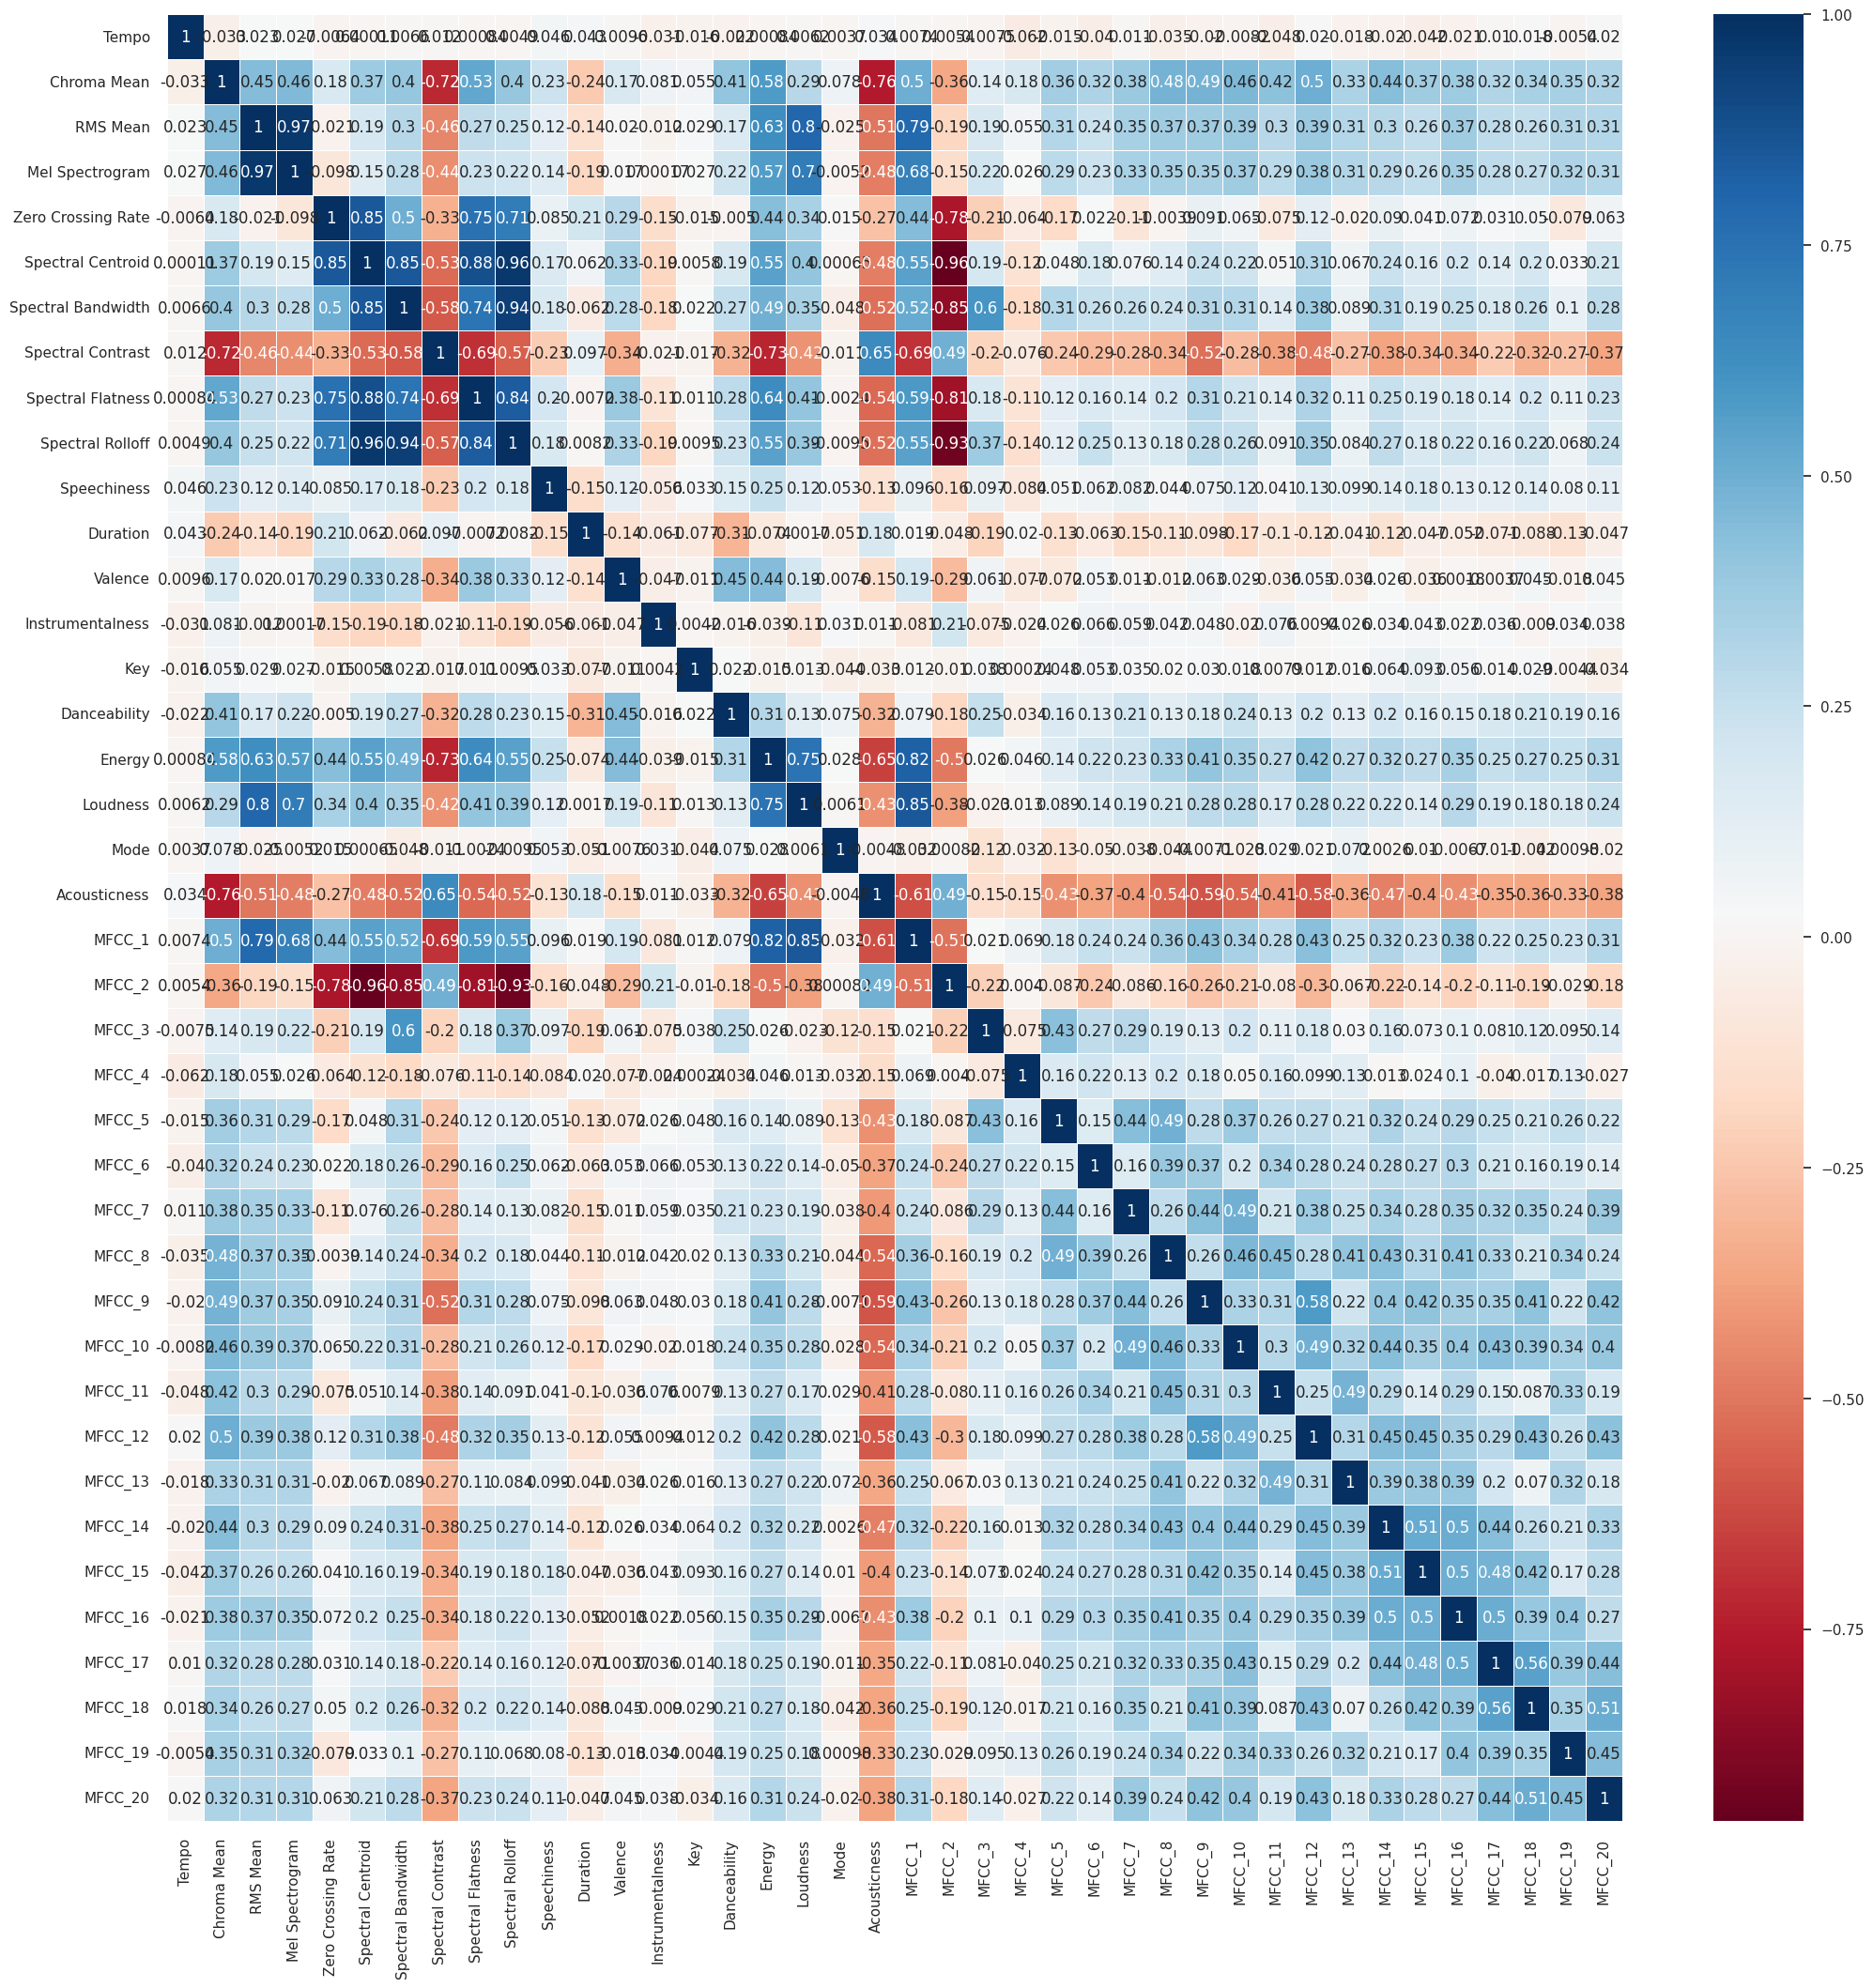

In [13]:
drop_list = high_correlated_cols(df, plot=True)

In [14]:
drop_list

['Mel Spectrogram',
 'Spectral Centroid',
 'Spectral Bandwidth',
 'Spectral Contrast',
 'Spectral Flatness',
 'Spectral Rolloff',
 'Energy',
 'Loudness',
 'Acousticness',
 'MFCC_1',
 'MFCC_2']

# Min - Max Normalization

In [15]:
spo_cols = ["Acousticness","Mode","Loudness","Energy",
            "Danceability","Key","Instrumentalness","Valence",
            "Duration","Speechiness"]

In [16]:
X = df.drop("Track Name", axis=1)
#X.drop(drop_list,axis=1,inplace=True)

In [17]:
scaler = MinMaxScaler()

In [18]:
X = pd.DataFrame(scaler.fit_transform(X), columns= X.columns)

#GLSPCA

In [19]:
feature_names = X.columns
scores = lap_score.lap_score(X.to_numpy())

pca = PCA(n_components=2)
pca_fit = pca.fit_transform(X)

# Combine the Laplacian scores and PCA scores
scores = np.hstack((scores, pca_fit[:, 0]))


# Select the top features
indices = np.argsort(scores)[::-1]

# Print the selected features
top_k_features = feature_names[indices[:19]]
print("Most important features:", top_k_features)


Most important features: Index(['MFCC_1', 'Danceability', 'Spectral Rolloff', 'Duration', 'Speechiness', 'Zero Crossing Rate', 'Valence', 'Spectral Contrast', 'Mel Spectrogram', 'Spectral Centroid', 'MFCC_11', 'MFCC_2', 'Key', 'Acousticness', 'RMS Mean', 'Mode', 'Spectral Flatness', 'Energy', 'Tempo'], dtype='object')


In [20]:
X_new = X[top_k_features]

# Dimansionality Reduction

In [21]:
pca = PCA(n_components=2)
pca_fit = pca.fit_transform(X_new)
kmeans_per_k = [KMeans(n_clusters=k, init="k-means++", random_state=42, n_init=300).fit(pca_fit) for k in range (3,10)]
silhouette_scores = [silhouette_score(pca_fit, model.labels_) for model in kmeans_per_k]
print(f"Sil. scores for 2 dimensions:")
print(silhouette_scores)

Sil. scores for 2 dimensions:
[0.5661972206975546, 0.6040222807830218, 0.568703758774827, 0.5548584927077409, 0.5338255374935683, 0.5301285164570152, 0.5279419725914599]


In [22]:
tsne = TSNE(n_components=2)
tsne_fit = tsne.fit_transform(X_new)
kmeans_per_k = [KMeans(n_clusters=k, init="k-means++", random_state=42, n_init=300).fit(tsne_fit) for k in range (3,10)]
silhouette_scores = [silhouette_score(tsne_fit, model.labels_) for model in kmeans_per_k]
print(f"Sil. scores for 2 dimensions:")
print(silhouette_scores)

Sil. scores for 2 dimensions:
[0.54277015, 0.47855568, 0.45670313, 0.4403197, 0.4417556, 0.43634728, 0.43069962]


In [23]:
ica = FastICA(n_components=2)
ica_fit = ica.fit_transform(X_new)
kmeans_per_k = [KMeans(n_clusters=k, init="k-means++", random_state=42, n_init=300).fit(ica_fit) for k in range (3,10)]
silhouette_scores = [silhouette_score(ica_fit, model.labels_) for model in kmeans_per_k]
print(f"Sil. scores for 2 dimensions:")
print(silhouette_scores)

Sil. scores for 2 dimensions:
[0.571793015325071, 0.6056007506231605, 0.5691525625166967, 0.553677306727005, 0.5328769999148419, 0.5287385700181584, 0.525821177822376]


# Elbow Method

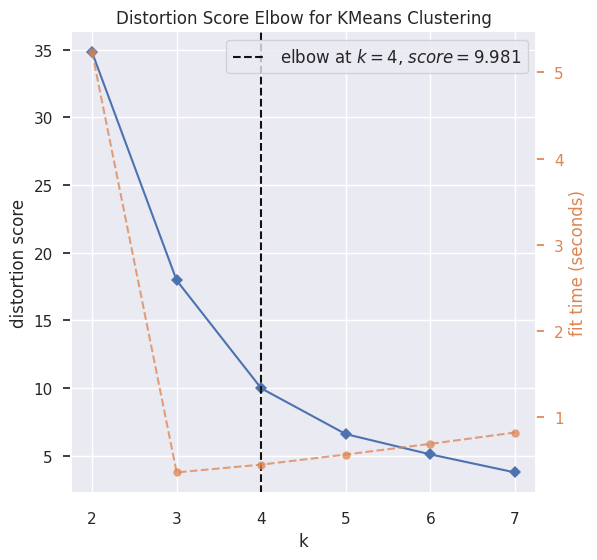

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [27]:
model = KMeans(init="k-means++", random_state=42, n_init=200)
plt.figure(figsize=(6,6))
visualizer = KElbowVisualizer(model, k=(2, 8))
visualizer.fit(pca_fit)
visualizer.show()
plt.savefig("elbow.png")

# Final K-means

In [28]:
final_model = KMeans(n_clusters=4, init="k-means++", random_state=42, n_init=1000)

In [29]:
final_model.fit(pca_fit)

KMeans(n_clusters=4, n_init=1000, random_state=42)

In [33]:
silhouette_score(pca_fit, final_model.labels_)

0.6040222807830218

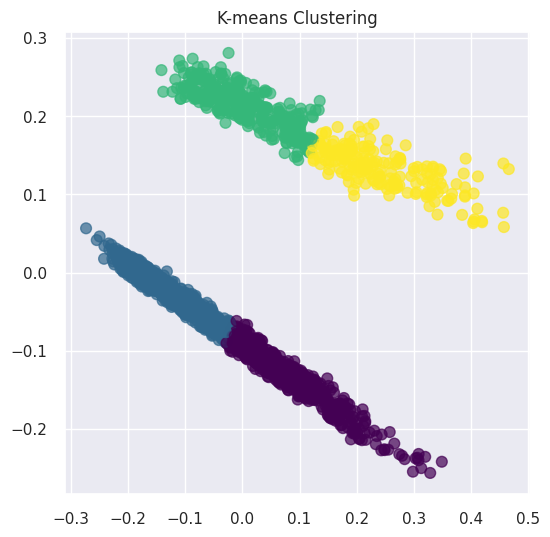

<Figure size 2500x2500 with 0 Axes>

In [34]:
plt.figure(figsize=(6,6))
plt.scatter(pca_fit[:, 0], pca_fit[:, 1], c=final_model.labels_, cmap='viridis', s=60, alpha=0.7)
plt.title('K-means Clustering')
plt.show()
plt.savefig("k-means_clustering.png")

In [38]:
X["Cluster"] = final_model.labels_

In [39]:
X["Cluster"].value_counts()

1    769
0    584
2    335
3    194
Name: Cluster, dtype: int64

In [49]:
cluster0 = df[X['Cluster'] == 0]
cluster1 = df[X['Cluster'] == 1]
cluster2 = df[X['Cluster'] == 2]
cluster3 = df[X['Cluster'] == 3]

In [50]:
cluster0.to_excel("cluster0.xlsx", index=False)
cluster1.to_excel("cluster1.xlsx", index=False)
cluster2.to_excel("cluster2.xlsx", index=False)
cluster3.to_excel("cluster3.xlsx", index=False)

In [47]:
data["Cluster"] = final_model.labels_

In [48]:
data.to_excel("tracks_with_labels.xlsx", index=False)

# DBSCAN

In [52]:
D = pca_fit.shape[1]
min_pts = D*2

In [53]:
knn = NearestNeighbors(n_neighbors=min_pts).fit(ica_fit)

In [54]:
distances, _ = knn.kneighbors(ica_fit)

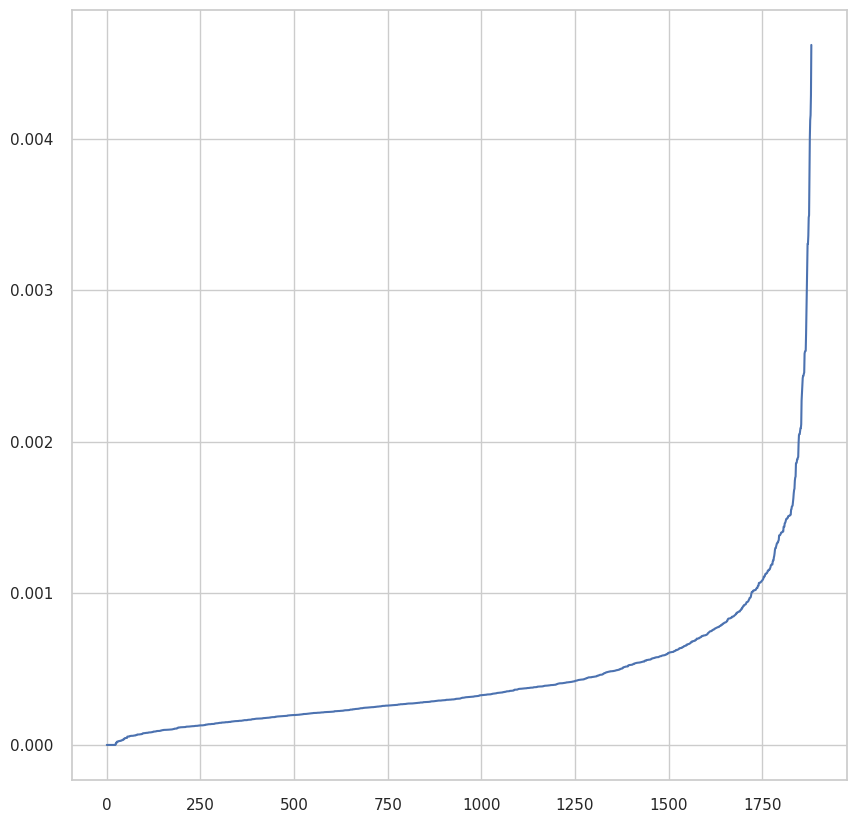

In [55]:
plt.figure(figsize=(10,10))
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

In [56]:
def get_scores_and_labels(combinations, X):
  scores = []
  all_labels_list = []

  for i, (eps, num_samples) in enumerate(combinations):
    dbscan_cluster_model = DBSCAN(eps=eps, min_samples=num_samples).fit(X)
    labels = dbscan_cluster_model.labels_
    labels_set = set(labels)
    num_clusters = len(labels_set)

    if -1 in labels_set:
      num_clusters -= 1

    c = (eps, num_samples)
    if (num_clusters < 3) or (num_clusters > 60):
      scores.append(-10)
      all_labels_list.append('bad')
      print(f"Combination {c} on iteration {i+1} has {num_clusters} clusters. Moving on")
      continue

    scores.append(silhouette_score(X, labels))
    all_labels_list.append(labels)
    print(f"Combination: {c} Index: {i}, Score: {scores[-1]}, Labels: {all_labels_list[-1]}, NumClusters: {num_clusters}")

  best_index = np.argmax(scores)
  best_parameters = combinations[best_index]
  best_labels = all_labels_list[best_index]
  best_score = scores[best_index]

  return {'best_epsilon': best_parameters[0],
          'best_min_samples': best_parameters[1],
          'best_labels': best_labels,
          'best_score': best_score,
          }

In [57]:
epsilons =  np.arange(0.0040, 0.0070, 0.0001)
min_samples = np.arange(50, 150, step=1)
combinations = list(itertools.product(epsilons, min_samples))

In [58]:
best_dict = get_scores_and_labels(combinations, ica_fit)

Combination: (0.004, 50) Index: 0, Score: 0.37564198047232356, Labels: [1 0 1 ... 0 0 0], NumClusters: 4
Combination: (0.004, 51) Index: 1, Score: 0.37064764382767884, Labels: [1 0 1 ... 0 0 0], NumClusters: 3
Combination (0.004, 52) on iteration 3 has 2 clusters. Moving on
Combination (0.004, 53) on iteration 4 has 2 clusters. Moving on
Combination (0.004, 54) on iteration 5 has 2 clusters. Moving on
Combination (0.004, 55) on iteration 6 has 2 clusters. Moving on
Combination (0.004, 56) on iteration 7 has 2 clusters. Moving on
Combination (0.004, 57) on iteration 8 has 2 clusters. Moving on
Combination (0.004, 58) on iteration 9 has 2 clusters. Moving on
Combination (0.004, 59) on iteration 10 has 2 clusters. Moving on
Combination (0.004, 60) on iteration 11 has 2 clusters. Moving on
Combination (0.004, 61) on iteration 12 has 2 clusters. Moving on
Combination (0.004, 62) on iteration 13 has 2 clusters. Moving on
Combination (0.004, 63) on iteration 14 has 2 clusters. Moving on
Combi

In [59]:
best_dict

{'best_epsilon': 0.005800000000000005,
 'best_min_samples': 50,
 'best_labels': array([0, 1, 0, ..., 1, 1, 1]),
 'best_score': 0.48913397378389045}

In [61]:
dbscan = DBSCAN(eps=0.0058, min_samples=50).fit(pca_fit)

In [62]:
labels = dbscan.labels_

In [ ]:
unique_values, counts = np.unique(labels, return_counts=True)
for value, count in zip(unique_values, counts):
    print(f"{value}: {count}")

#HDBSCAN

In [64]:
hdb = hdbscan.HDBSCAN(min_cluster_size=4, gen_min_span_tree=True)

In [65]:
hdb.fit(pca_fit)

HDBSCAN(gen_min_span_tree=True, min_cluster_size=4)

In [66]:
labels = hdb.labels_

In [67]:
unique_values, counts = np.unique(labels, return_counts=True)
for value, count in zip(unique_values, counts):
    print(f"{value}: {count}")

-1: 7
0: 529
1: 8
2: 1338


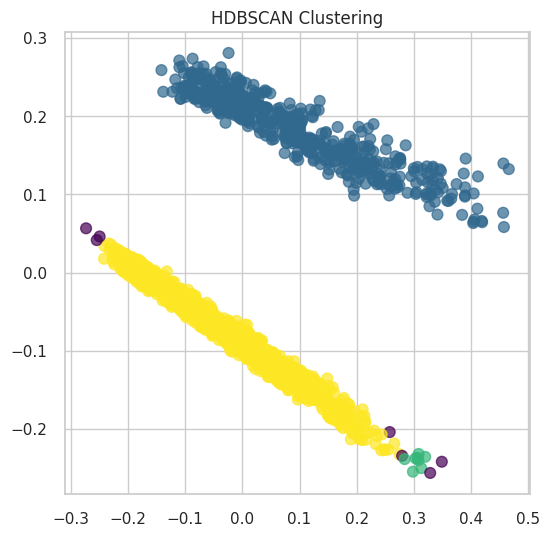

In [69]:
plt.figure(figsize=(6,6))
plt.scatter(pca_fit[:, 0], pca_fit[:, 1], c=labels, cmap='viridis', s=60, alpha=0.7)
plt.title('HDBSCAN Clustering')
plt.savefig("hdbscan_clustering.png")
plt.show()

In [70]:
silhouette_avg = silhouette_score(pca_fit, labels)
print("Silhouette Score:", silhouette_avg)

Silhouette Score: 0.47268127203875987




# Feature Selection(Cancelled)

In [ ]:
"""def generate_combinations(features, r):
    return list(combinations(features, r))"""

In [ ]:
"""
def evaluate_feature_combinations(X, feature_combinations, n_clusters_range=range(3, 9)):
    results = {}

    for features in tqdm(feature_combinations, desc="Processing feature combinations"):
        X_subset = X[list(features)]

        tsne = TSNE(n_components=2)
        tsne_fit = tsne.fit_transform(X_subset)

        silhouette_scores = []

        for n_clusters in n_clusters_range:
            kmeans_model = KMeans(n_clusters=n_clusters, init="k-means++", random_state=42, n_init=300)
            kmeans_model.fit(tsne_fit)
            silhouette = silhouette_score(tsne_fit, kmeans_model.labels_)
            silhouette_scores.append(silhouette)

        results[features] = {
            'silhouette_scores': silhouette_scores,
            'best_silhouette_score': max(silhouette_scores),
            'best_n_clusters': n_clusters_range[np.argmax(silhouette_scores)]
        }

    return results
"""

In [ ]:
"""batch_size = 200
feature_combinations = []
results = {}
for r in range(2, 20):
    feature_combinations.extend(generate_combinations(X.columns, r))
    if len(feature_combinations) >= batch_size:
        batch_results = evaluate_feature_combinations(X, feature_combinations)
        results.update(batch_results)
        feature_combinations = []

if feature_combinations:
    batch_results = evaluate_feature_combinations(X, feature_combinations)
    results.update(batch_results)
  """

In [ ]:
"""best_combination = max(results, key=lambda x: results[x]['best_silhouette_score'])
best_silhouette_score = results[best_combination]['best_silhouette_score']
best_n_clusters = results[best_combination]['best_n_clusters']"""

In [ ]:
"""def feature_selection_kmeans(X, n_cluster_range=(3, 5)):
    best_features = None
    best_score = -1

    for n_cluster in range(n_cluster_range[0], n_cluster_range[1] + 1):
        combinations_list = list(combinations(X.columns, n_cluster))

        for features_combination in tqdm(combinations_list, desc=f'n_cluster={n_cluster}', position=0, leave=True):
            subset_X = X[list(features_combination)]
            kmeans = KMeans(n_clusters=n_cluster,init="k-means++", n_init=200, random_state=42)
            kmeans.fit(subset_X)
            labels = kmeans.labels_
            silhouette_avg = silhouette_score(subset_X, labels)

            if silhouette_avg > best_score:
                best_score = silhouette_avg
                best_features = list(features_combination)

    return best_features, best_score"""


In [ ]:
"""best_features, best_score = feature_selection_kmeans(X)"""

In [ ]:
"""print(f"Best Score: {best_score}")"""

In [ ]:
"""print(f"Best Features: {best_features}")"""

# Feature Selection 2(Cancelled)

In [ ]:
def cluster_and_evaluate(data: pd.DataFrame, k_range: Tuple[int, int] = (3, 5)) -> Tuple[Dict, Tuple, int, float]:
    features = data.columns

    results: Dict[Tuple, List[Dict[str, int]]] = {
        combo: [{'k': k, 'silhouette': silhouette_score(data[list(combo)], KMeans(n_clusters=k, init="k-means++", random_state=42, n_init=300).fit_predict(data[list(combo)]))}
                for k in range(k_range[0], k_range[1] + 1)]
        for combo in tqdm(combinations(features, 10), desc=f'Calculating...', position=0, leave=True)
    }

    best_combination = max(results, key=lambda combo: max(result['silhouette'] for result in results[combo]))
    best_result = results[best_combination]
    best_k = best_result[0]['k']
    best_score = max(result['silhouette'] for result in best_result)

    return results, best_combination, best_k, best_score

In [ ]:
results, best_combination, best_k, best_score = cluster_and_evaluate(X)

Calculating...: 99it [1:32:20, 48.90s/it]

KeyboardInterrupt: 

Exception ignored in: 'sklearn.cluster._k_means_common._relocate_empty_clusters_dense'
Traceback (most recent call last):
  File "<__array_function__ internals>", line 177, in where
KeyboardInterrupt: 


In [ ]:
print("\nBest Combination:")
print(f"Kume Sayisi: {best_k}, En Iyi Kombinasyon: {best_combination}, Silhouette Skoru: {best_score}")

In [ ]:
print("Results:")
for combo, result_list in results.items():
    print(f"Combination {combo}:")
    for result in result_list:
        print(f"  K: {result['k']}, Silhouette: {result['silhouette']}")